# 3D medical image segmentation with one slice annotation

This notebook shows how to use SAM 2 for interactive segmentation in 3D images. It will cover the following:

- propagating a mask to get _masklets_ throughout the video

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

### Loading the SAM 2 video predictor

In [3]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam21_128.pth"
model_cfg = "configs/sam2.1/sam2.1_hiera_b+.yaml"
#sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
#model_cfg = "sam2_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint)

In [4]:
# def show_mask(mask, ax, obj_id=None, random_color=False):
#     if random_color:
#         color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
#     else:
#         cmap = plt.get_cmap("tab10")
#         cmap_idx = 0 if obj_id is None else obj_id
#         color = np.array([*cmap(cmap_idx)[:3], 0.6])
#     h, w = mask.shape[-2:]
#     mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
#     ax.imshow(mask_image)

# Color masks Red Green and Blue
def show_mask(mask, ax, random_color=False):
    # Define colors for each class (RGBA for transparency)
    colors = {
        0: np.array([0.0, 0.0, 0.0, 0.0]),  # Transparent background
        1: np.array([1.0, 0.0, 0.0, 0.6]),  # Red for class 1
        2: np.array([0.0, 1.0, 0.0, 0.6]),  # Green for class 2
        3: np.array([0.0, 0.0, 1.0, 0.6])   # Blue for class 3
    }

    # Random color option
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        mask_image = mask.reshape(mask.shape[0], mask.shape[1], 1) * color.reshape(1, 1, -1)
    else:
        # Initialize an empty image with the same shape as the mask but with RGBA channels
        h, w = mask.shape[-2:]
        mask_image = np.zeros((h, w, 4))

        # Apply color based on class value
        for class_id, color in colors.items():
            mask_image += (mask == class_id).reshape(h, w, 1) * color.reshape(1, 1, -1)

    ax.imshow(mask_image)
    ax.axis("off")


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

#### Select an example video

We assume that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

len of frames:  7


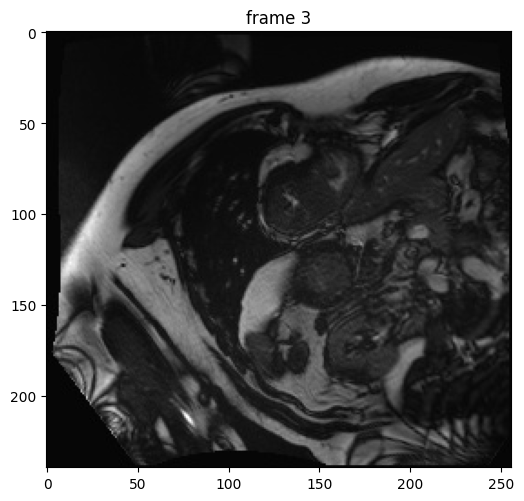

In [5]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./videos/cardiac"
#video_dir = "./videos/cardiac_mnm"
#video_dir = "./videos/miccai"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))
print("len of frames: ", len(frame_names))

# take a look the first video frame
frame_idx = len(frame_names) // 2
plt.figure(figsize=(6, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])), cmap='gray')

#### Initialize the inference state

load one mask

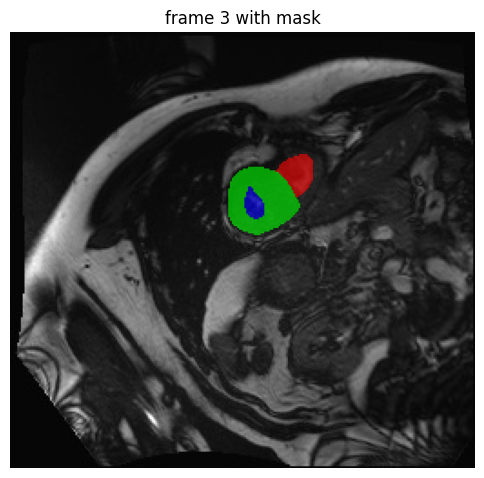

In [6]:
out_mask_logits = np.load(os.path.join(video_dir, frame_names[frame_idx].replace(".jpg", ".npy")))
plt.figure(figsize=(6, 6))
plt.title(f"frame {frame_idx} with mask")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])), cmap ='gray')
show_mask(out_mask_logits, plt.gca())

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).
#### Propagate the prompts to get the masklet across the video

In [7]:
# run propagation to get the mask for the entire video
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|█████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 238.44it/s]


In [8]:
ann_obj_id = 1

# Initialize dictionaries to store video segments for each class
class_1_segments = {}
class_2_segments = {}
class_3_segments = {}

for class_id in [1, 2, 3]:
    
    # Need to reset state for each class
    predictor.reset_state(inference_state)
    
    # Add new mask for the current class
    predictor.add_new_mask(inference_state=inference_state, frame_idx=frame_idx, obj_id=ann_obj_id, mask=out_mask_logits == class_id)
    
    # Initialize video_segments for this class
    video_segments = {}  # video_segments contains the per-frame segmentation results

    # Direct propagation   
    for out_frame_idx, out_obj_ids, class_mask in predictor.propagate_in_video(inference_state):
        # Store results for the current class in the appropriate variable
        for i, out_obj_id in enumerate(out_obj_ids):
            class_mask_np = (class_mask[i] > 0.0).cpu().numpy()
            if class_id == 1:
                class_1_segments[out_frame_idx] = {out_obj_id: class_mask_np}
            elif class_id == 2:
                class_2_segments[out_frame_idx] = {out_obj_id: class_mask_np}
            elif class_id == 3:
                class_3_segments[out_frame_idx] = {out_obj_id: class_mask_np}

    # Reverse propagation    
    for out_frame_idx, out_obj_ids, class_mask in predictor.propagate_in_video(inference_state, start_frame_idx=frame_idx-1, reverse=True):
        # Store results for the current class in the appropriate variable
        for i, out_obj_id in enumerate(out_obj_ids):
            class_mask_np = (class_mask[i] > 0.0).cpu().numpy()
            if class_id == 1:
                class_1_segments[out_frame_idx] = {out_obj_id: class_mask_np}
            elif class_id == 2:
                class_2_segments[out_frame_idx] = {out_obj_id: class_mask_np}
            elif class_id == 3:
                class_3_segments[out_frame_idx] = {out_obj_id: class_mask_np}


propagate in video:   0%|                                                                        | 0/4 [00:00<?, ?it/s]C:\Users\Windows\Desktop\Tijana\sam2-main\sam2-main\sam2\modeling\sam\transformer.py:344: UserWarning: Memory efficient kernel not used because: (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:778.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
C:\Users\Windows\Desktop\Tijana\sam2-main\sam2-main\sam2\modeling\sam\transformer.py:344: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/transformers/sdp_utils_cpp.h:558.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
C:\Users\Windows\Desktop\Tijana\sam2-main\sam2-main\sam2\modeling\sam\transformer.py:344: UserWarning: Flash attention kernel not used because: (Tri

In [9]:
# Initialize a global counter to track the color cycle
color_cycle = [np.array([1.0, 0.0, 0.0, 0.6]),  # Red
               np.array([0.0, 1.0, 0.0, 0.6]),  # Green
               np.array([0.0, 0.0, 1.0, 0.6])]  # Blue

color_index = 0  # Start with red

def show_mask_sam(mask, ax, random_color=False):
    global color_index  # Use the global color_index to track color

    # Get the current color from the cycle
    color = color_cycle[color_index]

    # Random color option (if needed)
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        mask_image = mask.reshape(mask.shape[0], mask.shape[1], 1) * color.reshape(1, 1, -1)
    else:
        # Initialize an empty image with the same shape as the mask but with RGBA channels
        h, w = mask.shape[-2:]
        mask_image = np.zeros((h, w, 4))

        # Apply color based on the mask class
        mask_image += (mask == 1).reshape(h, w, 1) * color.reshape(1, 1, -1)

    # Show the mask
    ax.imshow(mask_image)
    ax.axis("off")

    # Update the color cycle (move to the next color)
    color_index = (color_index + 1) % len(color_cycle)


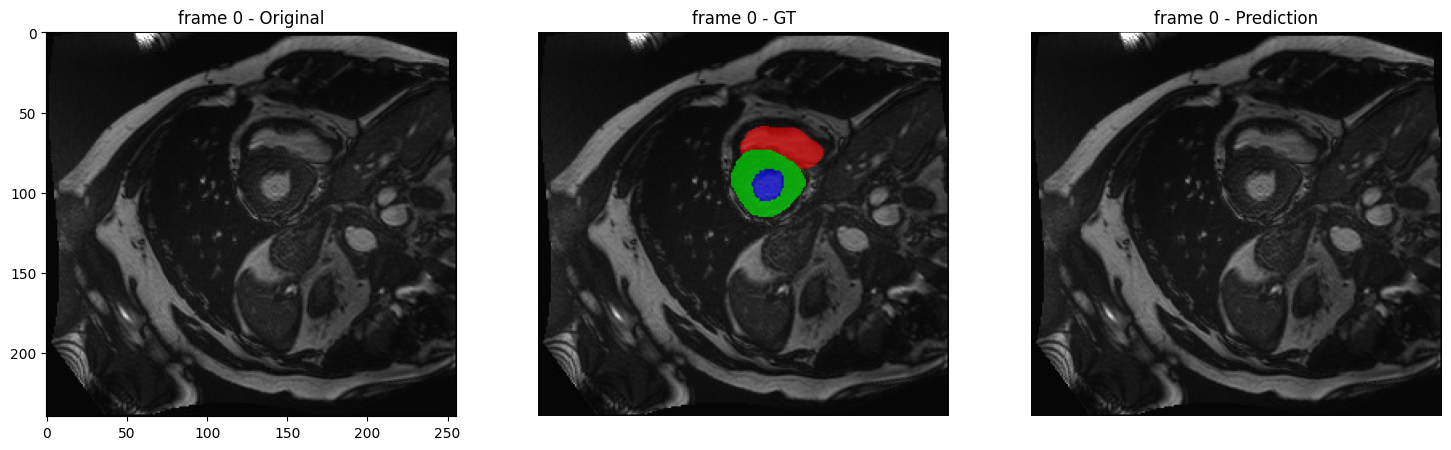

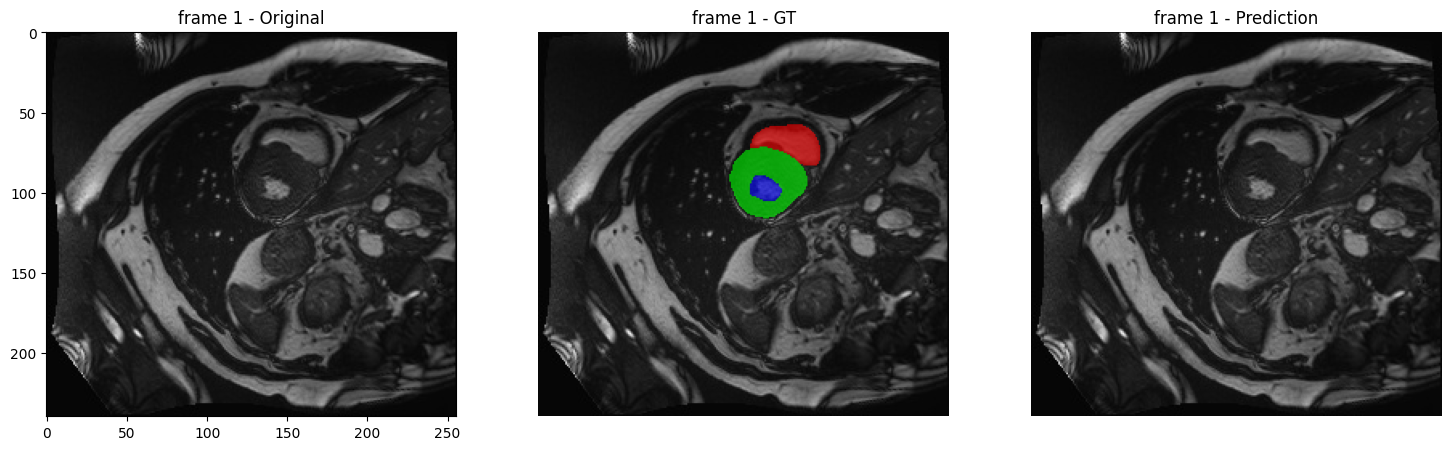

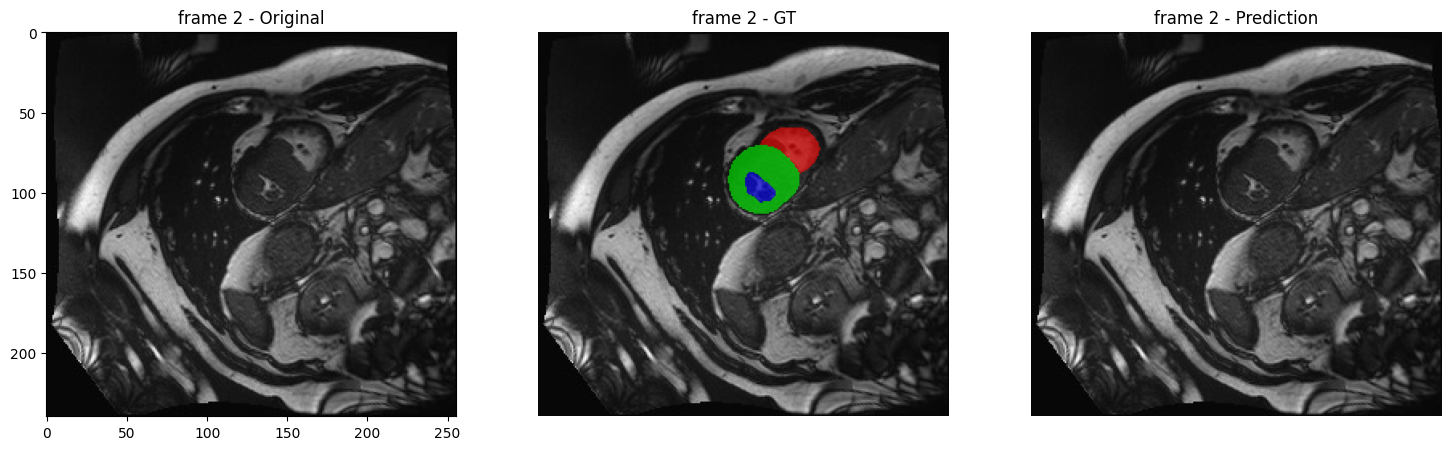

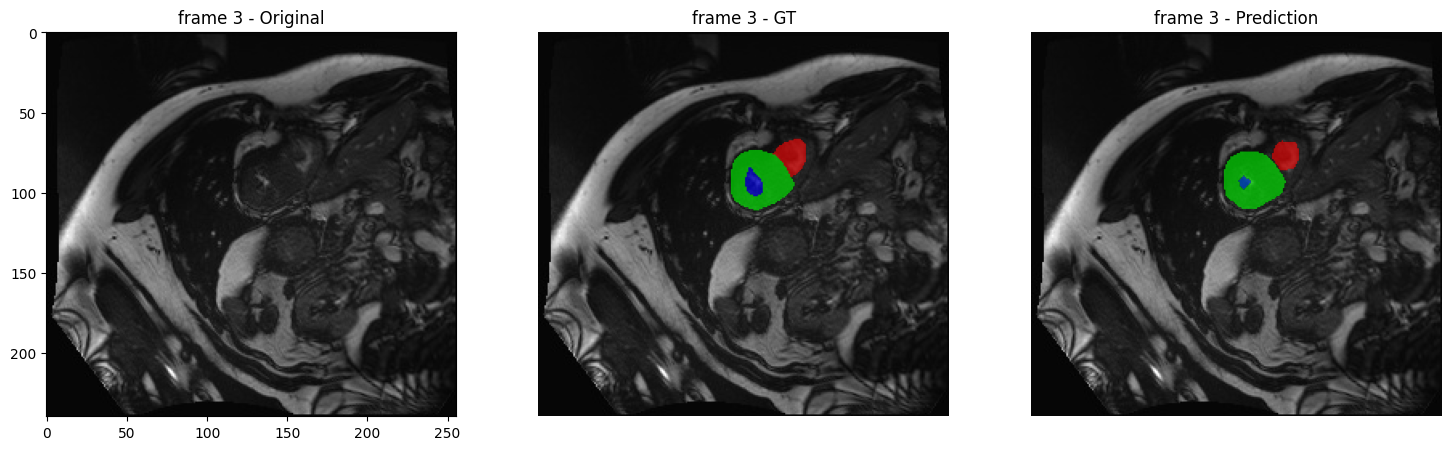

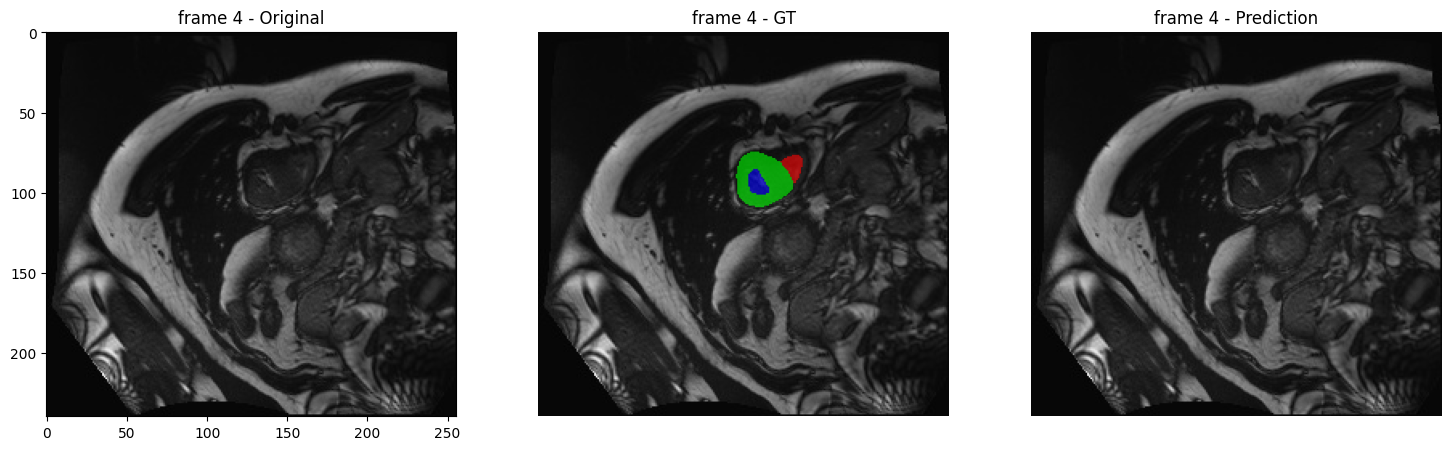

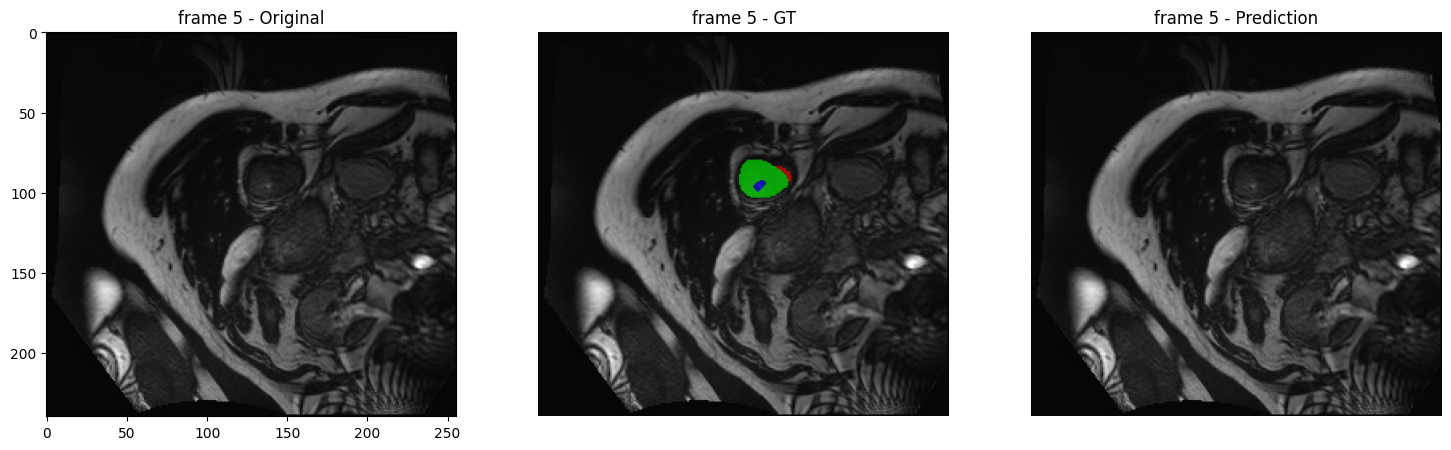

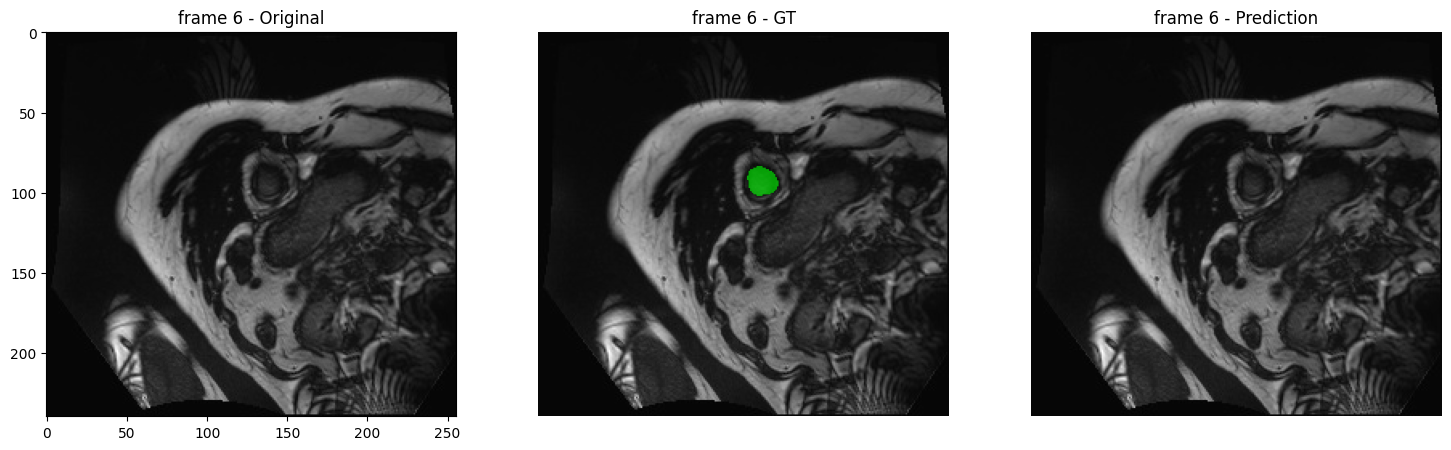

In [10]:
vis_frame_stride = 1

# Directory to save the figures
output_dir = "../output"
os.makedirs(output_dir, exist_ok=True)

plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    fig, axes = plt.subplots(1, 3, figsize=(18, 8))  
    # subplot
    axes[0].set_title(f"frame {out_frame_idx} - Original")
    original_image = Image.open(os.path.join(video_dir, frame_names[out_frame_idx]))
    axes[0].imshow(original_image,cmap='gray')
    
    # Ground truth subplot
    axes[1].set_title(f"frame {out_frame_idx} - GT")
    gt_image = Image.open(os.path.join(video_dir, frame_names[out_frame_idx]))
    axes[1].imshow(gt_image,cmap='gray')
    out_mask_logits_gt = np.load(os.path.join(video_dir, frame_names[out_frame_idx].replace(".jpg", ".npy")))
    show_mask(out_mask_logits_gt, axes[1])
    
    # Predicted result subplot
    axes[2].set_title(f"frame {out_frame_idx} - Prediction")
    pred_image = Image.open(os.path.join(video_dir, frame_names[out_frame_idx]))
    axes[2].imshow(pred_image, cmap='gray')

    # Assuming axes[2] is the plot axis
    for out_obj_id, out_mask in class_1_segments[out_frame_idx].items():
        show_mask_sam(out_mask, axes[2])          
    for out_obj_id, out_mask in class_2_segments[out_frame_idx].items():
       show_mask_sam(out_mask, axes[2])  
    for out_obj_id, out_mask in class_3_segments[out_frame_idx].items():
       show_mask_sam(out_mask, axes[2])

    # Save the figure to the output directory
    save_path = os.path.join(output_dir, f"frame_{out_frame_idx}.png")
    plt.savefig(save_path, bbox_inches='tight')
    
    plt.show()


In [11]:
# Class LV
video_seg_3d_1 = np.stack([class_1_segments[k][1] for k in class_1_segments])
video_seg_3d_2 = np.stack([class_2_segments[k][1] for k in class_2_segments])
video_seg_3d_3 = np.stack([class_3_segments[k][1] for k in class_3_segments])
#gt_3d = np.stack([np.load(os.path.join(video_dir, frame_names[k].replace(".jpg", ".npy")))[None] for k in class_1_segments])

# Initialize empty lists to hold the 3D arrays for each class (0, 1, 2, 3)
gt_3d_class_0 = []
gt_3d_class_1 = []
gt_3d_class_2 = []
gt_3d_class_3 = []

# Iterate through class_1_segments to load the .npy files and process them
for k in class_1_segments:
    # Load the .npy file corresponding to frame_names[k]
    frame_path = os.path.join(video_dir, frame_names[k].replace(".jpg", ".npy"))
    mask = np.load(frame_path)
    
    # Create separate binary masks for each class (0, 1, 2, 3)
    mask_class_0 = (mask == 0).astype(np.uint8)  # 1 for class 0, 0 otherwise
    mask_class_1 = (mask == 1).astype(np.uint8)  # 1 for class 1, 0 otherwise
    mask_class_2 = (mask == 2).astype(np.uint8)  # 1 for class 2, 0 otherwise
    mask_class_3 = (mask == 3).astype(np.uint8)  # 1 for class 3, 0 otherwise
    
    # Append each binary mask (with new axis) to the corresponding list
    gt_3d_class_0.append(mask_class_0[None])  # Shape will be (1, height, width)
    gt_3d_class_1.append(mask_class_1[None])
    gt_3d_class_2.append(mask_class_2[None])
    gt_3d_class_3.append(mask_class_3[None])

# Stack the lists into 3D arrays
gt_3d_class_0 = np.stack(gt_3d_class_0)  # Shape: (num_frames, 1, height, width)
gt_3d_class_1 = np.stack(gt_3d_class_1)
gt_3d_class_2 = np.stack(gt_3d_class_2)
gt_3d_class_3 = np.stack(gt_3d_class_3)


In [12]:
import torch
from monai.metrics import DiceHelper, compute_surface_dice

# Class RV
n_classes, batch_size = 1, 1
spatial_shape = (video_seg_3d_1.shape[0], video_seg_3d_1.shape[2], video_seg_3d_1.shape[3]) 

y_pred = torch.tensor(video_seg_3d_1).float().reshape(batch_size, n_classes, *spatial_shape)  # prediction
y = torch.tensor(gt_3d_class_1).float().reshape(batch_size, n_classes, *spatial_shape)  # ground truth

score, not_nans = DiceHelper(include_background=False, sigmoid=True, softmax=True)(y_pred, y)
print('RV dice score:', score)

# Class MYO
spatial_shape = (video_seg_3d_2.shape[0], video_seg_3d_2.shape[2], video_seg_3d_2.shape[3]) 

y_pred = torch.tensor(video_seg_3d_2).float().reshape(batch_size, n_classes, *spatial_shape)  # prediction
y = torch.tensor(gt_3d_class_2).float().reshape(batch_size, n_classes, *spatial_shape)  # ground truth

score, not_nans = DiceHelper(include_background=False, sigmoid=True, softmax=True)(y_pred, y)
print('MYO dice score:', score)

# Class LV
spatial_shape = (video_seg_3d_3.shape[0], video_seg_3d_3.shape[2], video_seg_3d_3.shape[3]) 

y_pred = torch.tensor(video_seg_3d_3).float().reshape(batch_size, n_classes, *spatial_shape)  # prediction
y = torch.tensor(gt_3d_class_3).float().reshape(batch_size, n_classes, *spatial_shape)  # ground truth

score, not_nans = DiceHelper(include_background=False, sigmoid=True, softmax=True)(y_pred, y)
print('LV dice score:', score)

RV dice score: tensor([0.1697])
MYO dice score: tensor([0.2516])
LV dice score: tensor([0.0697])


#### Calculate Dice and IoU for all test and write csv

In [13]:
import csv
import torch
from monai.metrics import DiceHelper, compute_surface_dice

# Define paths to image and mask directories
video_dir = "./videos/Test/"
#video_dir = "./videos/MedicalSAM2_Test/"
images_dir = os.path.join(video_dir, "image")
masks_dir = os.path.join(video_dir, "mask")

# Initialize an empty list to collect scores
results = []

# Iterate through each patient folder in the images directory
for patient_folder in os.listdir(images_dir):
    patient_images_path = os.path.join(images_dir, patient_folder)
    patient_masks_path = os.path.join(masks_dir, patient_folder)
    
    # Get all JPEG frame names in the patient's images folder
    frame_names = [
        p for p in os.listdir(patient_images_path)
        if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
    ]
    frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))  # Sort by frame number
    frame_idx = len(frame_names) // 2
   
    # Mask Ground truth
    print(patient_masks_path)
    out_mask_logits = np.load(os.path.join(patient_masks_path, frame_names[frame_idx].replace(".jpg", ".npy")))
    
    # run propagation to get the mask for the entire video
    inference_state = predictor.init_state(video_path=patient_images_path)
    
    ann_obj_id = 1
    
    # Initialize dictionaries to store video segments for each class
    class_1_segments = {}
    class_2_segments = {}
    class_3_segments = {}
    
    for class_id in [1, 2, 3]:
        
        # Need to reset state for each class
        predictor.reset_state(inference_state)
        
        # Add new mask for the current class
        predictor.add_new_mask(inference_state=inference_state, frame_idx=frame_idx, obj_id=ann_obj_id, mask=out_mask_logits == class_id)
        
        # Initialize video_segments for this class
        video_segments = {}  # video_segments contains the per-frame segmentation results
    
        # Direct propagation   
        for out_frame_idx, out_obj_ids, class_mask in predictor.propagate_in_video(inference_state):
            # Store results for the current class in the appropriate variable
            for i, out_obj_id in enumerate(out_obj_ids):
                class_mask_np = (class_mask[i] > 0.0).cpu().numpy()
                if class_id == 1:
                    class_1_segments[out_frame_idx] = {out_obj_id: class_mask_np}
                elif class_id == 2:
                    class_2_segments[out_frame_idx] = {out_obj_id: class_mask_np}
                elif class_id == 3:
                    class_3_segments[out_frame_idx] = {out_obj_id: class_mask_np}
    
        # Reverse propagation    
        for out_frame_idx, out_obj_ids, class_mask in predictor.propagate_in_video(inference_state, start_frame_idx=frame_idx-1, reverse=True):
            # Store results for the current class in the appropriate variable
            for i, out_obj_id in enumerate(out_obj_ids):
                class_mask_np = (class_mask[i] > 0.0).cpu().numpy()
                if class_id == 1:
                    class_1_segments[out_frame_idx] = {out_obj_id: class_mask_np}
                elif class_id == 2:
                    class_2_segments[out_frame_idx] = {out_obj_id: class_mask_np}
                elif class_id == 3:
                    class_3_segments[out_frame_idx] = {out_obj_id: class_mask_np}
    
    # Class LV
    video_seg_3d_1 = np.stack([class_1_segments[k][1] for k in class_1_segments])
    video_seg_3d_2 = np.stack([class_2_segments[k][1] for k in class_2_segments])
    video_seg_3d_3 = np.stack([class_3_segments[k][1] for k in class_3_segments])
    #gt_3d = np.stack([np.load(os.path.join(video_dir, frame_names[k].replace(".jpg", ".npy")))[None] for k in class_1_segments])
    
    # Initialize empty lists to hold the 3D arrays for each class (0, 1, 2, 3)
    gt_3d_class_0 = []
    gt_3d_class_1 = []
    gt_3d_class_2 = []
    gt_3d_class_3 = []
    
    # Iterate through class_1_segments to load the .npy files and process them
    for k in class_1_segments:
        # Load the .npy file corresponding to frame_names[k]
        frame_path = os.path.join(patient_masks_path, frame_names[k].replace(".jpg", ".npy"))
        mask = np.load(frame_path)
        
        # Create separate binary masks for each class (0, 1, 2, 3)
        mask_class_0 = (mask == 0).astype(np.uint8)  # 1 for class 0, 0 otherwise
        mask_class_1 = (mask == 1).astype(np.uint8)  # 1 for class 1, 0 otherwise
        mask_class_2 = (mask == 2).astype(np.uint8)  # 1 for class 2, 0 otherwise
        mask_class_3 = (mask == 3).astype(np.uint8)  # 1 for class 3, 0 otherwise
        
        # Append each binary mask (with new axis) to the corresponding list
        gt_3d_class_0.append(mask_class_0[None])  # Shape will be (1, height, width)
        gt_3d_class_1.append(mask_class_1[None])
        gt_3d_class_2.append(mask_class_2[None])
        gt_3d_class_3.append(mask_class_3[None])
    
    # Stack the lists into 3D arrays
    gt_3d_class_0 = np.stack(gt_3d_class_0)  # Shape: (num_frames, 1, height, width)
    gt_3d_class_1 = np.stack(gt_3d_class_1)
    gt_3d_class_2 = np.stack(gt_3d_class_2)
    gt_3d_class_3 = np.stack(gt_3d_class_3)
    
    # Class RV
    n_classes, batch_size = 1, 1
    
    spatial_shape = (video_seg_3d_1.shape[0], video_seg_3d_1.shape[2], video_seg_3d_1.shape[3]) 
    y_pred = torch.tensor(video_seg_3d_1).float().reshape(batch_size, n_classes, *spatial_shape)  # prediction
    y = torch.tensor(gt_3d_class_1).float().reshape(batch_size, n_classes, *spatial_shape)  # ground truth
    
    score, not_nans = DiceHelper(include_background=False, sigmoid=True, softmax=True)(y_pred, y)
    #print(f"Patient folder: {os.path.basename(patient_images_path)}, RV dice score: {score}")
    rv_score = score.item()  # Convert to Python float if it's a tensor
    
    # Class MYO
    spatial_shape = (video_seg_3d_2.shape[0], video_seg_3d_2.shape[2], video_seg_3d_2.shape[3]) 
    y_pred = torch.tensor(video_seg_3d_2).float().reshape(batch_size, n_classes, *spatial_shape)  # prediction
    y = torch.tensor(gt_3d_class_2).float().reshape(batch_size, n_classes, *spatial_shape)  # ground truth
    
    score, not_nans = DiceHelper(include_background=False, sigmoid=True, softmax=True)(y_pred, y)
    #print('MYO dice score:', score)
    myo_score = score.item()
    
    # Class LV
    spatial_shape = (video_seg_3d_3.shape[0], video_seg_3d_3.shape[2], video_seg_3d_3.shape[3]) 
    y_pred = torch.tensor(video_seg_3d_3).float().reshape(batch_size, n_classes, *spatial_shape)  # prediction
    y = torch.tensor(gt_3d_class_3).float().reshape(batch_size, n_classes, *spatial_shape)  # ground truth
    
    score, not_nans = DiceHelper(include_background=False, sigmoid=True, softmax=True)(y_pred, y)
    #print('LV dice score:', score)
    lv_score = score.item()

    # Append results for this patient
    results.append([os.path.basename(patient_images_path), rv_score, myo_score, lv_score])


# Write all results to CSV
csv_path = "sam21_128.csv"
with open(csv_path, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Patient Folder", "RV Dice Score", "MYO Dice Score", "LV Dice Score"])
    writer.writerows(results)

print(f"Dice scores saved to {csv_path}")

./videos/Test/mask\patient_frame01_patient101


propagate in video: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.72it/s]


./videos/Test/mask\patient_frame01_patient102


propagate in video: 100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 22.73it/s]


./videos/Test/mask\patient_frame01_patient103


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.74it/s]


./videos/Test/mask\patient_frame01_patient104


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.23it/s]


./videos/Test/mask\patient_frame01_patient105


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.93it/s]


./videos/Test/mask\patient_frame01_patient106


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.06it/s]


./videos/Test/mask\patient_frame01_patient107


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.21it/s]


./videos/Test/mask\patient_frame01_patient108


propagate in video: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.59it/s]


./videos/Test/mask\patient_frame01_patient109


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.93it/s]


./videos/Test/mask\patient_frame01_patient110


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.90it/s]


./videos/Test/mask\patient_frame01_patient111


propagate in video: 100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 19.11it/s]


./videos/Test/mask\patient_frame01_patient112


propagate in video: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.52it/s]


./videos/Test/mask\patient_frame01_patient113


propagate in video: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.02it/s]


./videos/Test/mask\patient_frame01_patient114


propagate in video: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.76it/s]


./videos/Test/mask\patient_frame01_patient115


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.11it/s]


./videos/Test/mask\patient_frame01_patient116


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.51it/s]


./videos/Test/mask\patient_frame01_patient117


propagate in video: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.32it/s]


./videos/Test/mask\patient_frame01_patient118


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.78it/s]


./videos/Test/mask\patient_frame01_patient119


propagate in video: 100%|████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 21.18it/s]


./videos/Test/mask\patient_frame01_patient120


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.57it/s]


./videos/Test/mask\patient_frame01_patient121


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.62it/s]


./videos/Test/mask\patient_frame01_patient122


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.41it/s]


./videos/Test/mask\patient_frame01_patient123


propagate in video: 100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 19.96it/s]


./videos/Test/mask\patient_frame01_patient124


propagate in video: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 20.41it/s]


./videos/Test/mask\patient_frame01_patient125


propagate in video: 100%|████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.53it/s]


./videos/Test/mask\patient_frame01_patient126


propagate in video: 100%|████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 20.68it/s]


./videos/Test/mask\patient_frame01_patient127


propagate in video: 100%|████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 20.95it/s]


./videos/Test/mask\patient_frame01_patient128


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.98it/s]


./videos/Test/mask\patient_frame01_patient129


propagate in video: 100%|████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 19.97it/s]


./videos/Test/mask\patient_frame01_patient130


propagate in video: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.49it/s]


./videos/Test/mask\patient_frame01_patient131


propagate in video: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.06it/s]


./videos/Test/mask\patient_frame01_patient132


propagate in video: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.21it/s]


./videos/Test/mask\patient_frame01_patient133


propagate in video: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.30it/s]


./videos/Test/mask\patient_frame01_patient134


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.51it/s]


./videos/Test/mask\patient_frame01_patient135


propagate in video: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.28it/s]


./videos/Test/mask\patient_frame01_patient136


propagate in video: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.11it/s]


./videos/Test/mask\patient_frame01_patient137


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.03it/s]


./videos/Test/mask\patient_frame01_patient138


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.58it/s]


./videos/Test/mask\patient_frame01_patient139


propagate in video: 100%|████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 21.39it/s]


./videos/Test/mask\patient_frame01_patient140


propagate in video: 100%|████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 20.83it/s]


./videos/Test/mask\patient_frame01_patient141


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.69it/s]


./videos/Test/mask\patient_frame01_patient142


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.05it/s]


./videos/Test/mask\patient_frame01_patient143


propagate in video: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.56it/s]


./videos/Test/mask\patient_frame01_patient144


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.00it/s]


./videos/Test/mask\patient_frame01_patient145


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.66it/s]


./videos/Test/mask\patient_frame01_patient146


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.44it/s]


./videos/Test/mask\patient_frame01_patient147


propagate in video: 100%|████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.30it/s]


./videos/Test/mask\patient_frame01_patient148


propagate in video: 100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 22.01it/s]


./videos/Test/mask\patient_frame01_patient149


propagate in video: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.60it/s]


./videos/Test/mask\patient_frame01_patient150


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.69it/s]


./videos/Test/mask\patient_frame06_patient122


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.28it/s]


./videos/Test/mask\patient_frame07_patient111


propagate in video: 100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 19.26it/s]


./videos/Test/mask\patient_frame07_patient124


propagate in video: 100%|████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 21.12it/s]


./videos/Test/mask\patient_frame07_patient125


propagate in video: 100%|████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 20.95it/s]


./videos/Test/mask\patient_frame07_patient126


propagate in video: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 20.98it/s]


./videos/Test/mask\patient_frame07_patient127


propagate in video: 100%|████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 19.98it/s]


./videos/Test/mask\patient_frame08_patient113


propagate in video: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.32it/s]


./videos/Test/mask\patient_frame08_patient120


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.61it/s]


./videos/Test/mask\patient_frame08_patient129


propagate in video: 100%|████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.48it/s]


./videos/Test/mask\patient_frame08_patient139


propagate in video: 100%|████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 20.99it/s]


./videos/Test/mask\patient_frame09_patient108


propagate in video: 100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 21.50it/s]


./videos/Test/mask\patient_frame09_patient116


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.67it/s]


./videos/Test/mask\patient_frame09_patient119


propagate in video: 100%|████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 20.36it/s]


./videos/Test/mask\patient_frame09_patient131


propagate in video: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.75it/s]


./videos/Test/mask\patient_frame09_patient140


propagate in video: 100%|████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 20.73it/s]


./videos/Test/mask\patient_frame09_patient144


propagate in video: 100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 20.10it/s]


./videos/Test/mask\patient_frame09_patient147


propagate in video: 100%|████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.06it/s]


./videos/Test/mask\patient_frame10_patient105


propagate in video: 100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 21.74it/s]


./videos/Test/mask\patient_frame10_patient107


propagate in video: 100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 19.76it/s]


./videos/Test/mask\patient_frame10_patient109


propagate in video: 100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 21.66it/s]


./videos/Test/mask\patient_frame10_patient118


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.67it/s]


./videos/Test/mask\patient_frame10_patient121


propagate in video: 100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 21.28it/s]


./videos/Test/mask\patient_frame10_patient133


propagate in video: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.75it/s]


./videos/Test/mask\patient_frame10_patient135


propagate in video: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.01it/s]


./videos/Test/mask\patient_frame10_patient138


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.57it/s]


./videos/Test/mask\patient_frame10_patient146


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.41it/s]


./videos/Test/mask\patient_frame10_patient148


propagate in video: 100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 18.98it/s]


./videos/Test/mask\patient_frame11_patient103


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.95it/s]


./videos/Test/mask\patient_frame11_patient104


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.69it/s]


./videos/Test/mask\patient_frame11_patient110


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.47it/s]


./videos/Test/mask\patient_frame11_patient114


propagate in video: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.32it/s]


./videos/Test/mask\patient_frame11_patient123


propagate in video: 100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 19.94it/s]


./videos/Test/mask\patient_frame11_patient128


propagate in video: 100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 20.31it/s]


./videos/Test/mask\patient_frame11_patient130


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.56it/s]


./videos/Test/mask\patient_frame11_patient137


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.87it/s]


./videos/Test/mask\patient_frame11_patient141


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.42it/s]


./videos/Test/mask\patient_frame12_patient112


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.69it/s]


./videos/Test/mask\patient_frame12_patient136


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.78it/s]


./videos/Test/mask\patient_frame12_patient142


propagate in video: 100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 18.29it/s]


./videos/Test/mask\patient_frame12_patient143


propagate in video: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.67it/s]


./videos/Test/mask\patient_frame12_patient149


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.54it/s]


./videos/Test/mask\patient_frame12_patient150


propagate in video: 100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 19.77it/s]


./videos/Test/mask\patient_frame13_patient102


propagate in video: 100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 20.01it/s]


./videos/Test/mask\patient_frame13_patient106


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.59it/s]


./videos/Test/mask\patient_frame13_patient115


propagate in video: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.04it/s]


./videos/Test/mask\patient_frame13_patient117


propagate in video: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.16it/s]


./videos/Test/mask\patient_frame13_patient145


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.62it/s]


./videos/Test/mask\patient_frame14_patient101


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.07it/s]


./videos/Test/mask\patient_frame15_patient132


propagate in video: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.13it/s]


./videos/Test/mask\patient_frame15_patient134


propagate in video: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.21it/s]

Dice scores saved to sam21_128.csv
